In [31]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [32]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [33]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [34]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:08, 89.28it/s]


### PPT Levels in different U.S. States


In [35]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

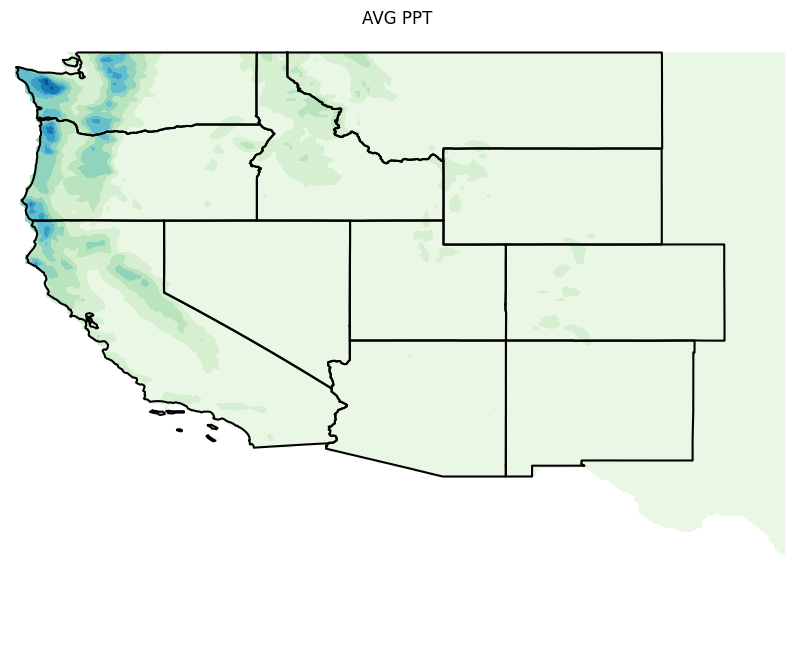

In [36]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [37]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:04, 363.92it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


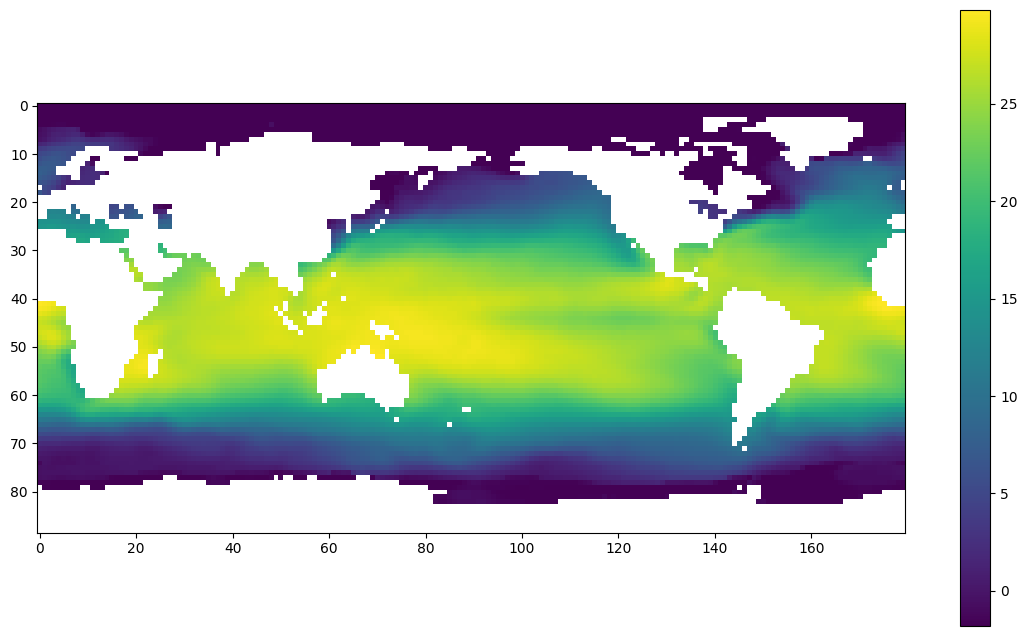

(1644,)

In [38]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [39]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [40]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [41]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [42]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [43]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [44]:
clusters = np.load("clusters.npy")

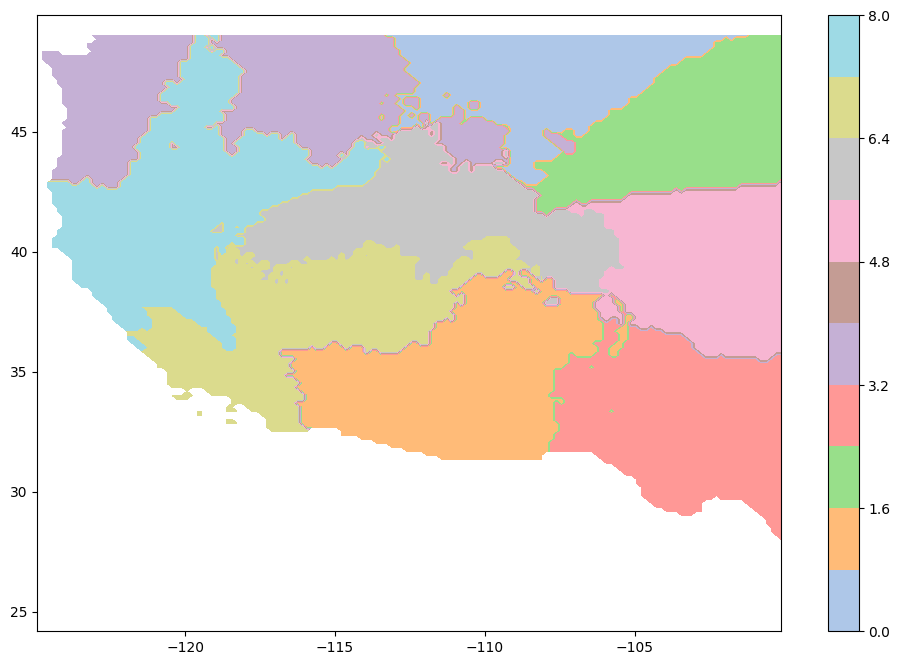

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [45]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [46]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_7121/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

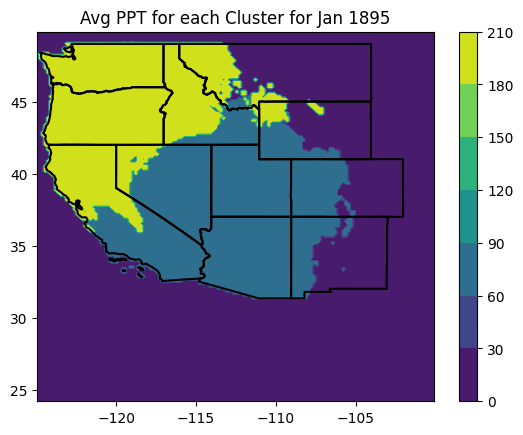

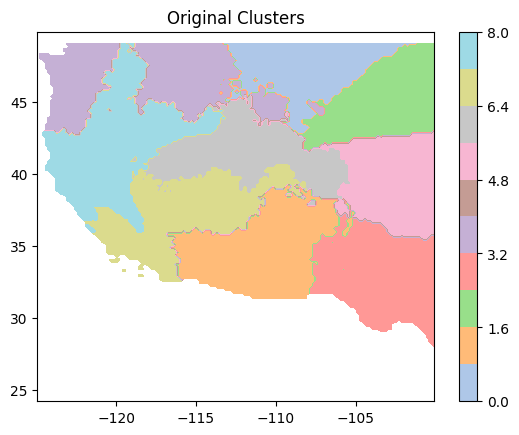

In [47]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [48]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_7121/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_7121/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [49]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [50]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [51]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## 6. Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing clusters


In [52]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
all_clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
all_clusters = np.array(all_clusters)

In [53]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [54]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Split y labels by month and process clusters


In [55]:
oct_labels = y_labels.index[y_labels.index.month == 10]
nov_labels = y_labels.index[y_labels.index.month == 11]
dec_labels = y_labels.index[y_labels.index.month == 12]
jan_labels = y_labels.index[y_labels.index.month == 1]
feb_labels = y_labels.index[y_labels.index.month == 2]
mar_labels = y_labels.index[y_labels.index.month == 3]

def split_clusters(month_num):
    ppt_data = np.array(y_labels[y_labels.index.month == month_num]["ppt_cluster_vector_quantized"]) - 1
    # get all 9 clusters in a list, where each cluster is the ith column in ppt_data
    clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
    return np.array(clusters)

oct_clusters = split_clusters(10)
nov_clusters = split_clusters(11)
dec_clusters = split_clusters(12)
jan_clusters = split_clusters(1)
feb_clusters = split_clusters(2)
mar_clusters = split_clusters(3)



## 7. Process SST data for PCA pre-processing with regions

We need to split the SST data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [56]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=4)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

(16,)

## 8. Chunk SST data to correspond to labels

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [57]:
def chunk_sst_to_label(ppt_labels, pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in ppt_labels:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

# Training data for all 6 months at once
sst_pca_all_months = chunk_sst_to_label(y_labels.index, sst_condensed_pca)

# Training data for each month
oct_sst_pca = chunk_sst_to_label(oct_labels, sst_condensed_pca)
nov_sst_pca = chunk_sst_to_label(nov_labels, sst_condensed_pca)
dec_sst_pca = chunk_sst_to_label(dec_labels, sst_condensed_pca)
jan_sst_pca = chunk_sst_to_label(jan_labels, sst_condensed_pca)
feb_sst_pca = chunk_sst_to_label(feb_labels, sst_condensed_pca)
mar_sst_pca = chunk_sst_to_label(mar_labels, sst_condensed_pca)

sst_24_months shape: (732, 384)
sst_24_months shape: (122, 384)
sst_24_months shape: (122, 384)
sst_24_months shape: (122, 384)
sst_24_months shape: (122, 384)
sst_24_months shape: (122, 384)
sst_24_months shape: (122, 384)


In [58]:
def get_cluster_data(sst_data, ppt_cluster_data, cluster_ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_data, ppt_cluster_data[cluster_ind], test_size=0.1)
    return X_train, X_test, y_train, y_test

## 9. Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [64]:
trials = []
conf_preds = []
conf_labels = []
importances = []
# recalls = []
# precisions = []
for trial in range(5):
    accuracies = []
    for i in range(len(all_clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(nov_sst_pca, nov_clusters, i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        importances.append(rf.feature_importances_)
        y_pred = rf.predict(X_test)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_test, y_pred))
        # precision, recall, _ = precision_recall_curve(y_test, y_pred)
        # precisions.append(precision)
        # recalls.append(recall)
        conf_preds.append(y_pred)
        conf_labels.append(y_test)  # changed to y_train to see if confusion matrix still skewed
    trials.append(accuracies)

trials = np.array(trials)
# recalls = np.array(recalls)
# precisions = np.array(precisions)
# get the mean accuracy for each cluster
np.savetxt("nov_4_comps.csv", trials, delimiter=",")
mean_accuracies = np.mean(trials, axis=0)
# mean_precisions = np.mean(precisions, axis=0)
# mean_recalls = np.mean(recalls, axis=0)
# precisions_and_recalls = np.stack((mean_precisions, mean_recalls), axis=-1)
# np.savetxt("mar_4_comps_precisions_and_recalls.csv", precisions_and_recalls, delimiter=",")

### Find Most Important Month


In [60]:
by_month = np.array(importances).reshape(45, 24, 16) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_month = np.mean(by_month, axis=2) # average the importances across the 8 features to get total importance for the month
by_month = np.sum(by_month, axis=0) # sum the importances across the 24 months to get total importance for all trials for that month
by_month


ValueError: cannot reshape array of size 86400 into shape (45,24,16)

### Find Most Important Region


In [ ]:
by_region = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_region.shape
by_region = np.mean(by_region, axis=1) # average the importances across the 24 months to get total importance for 8 features
by_region = np.sum(by_region, axis=0) # sum the importances across the 8 features to get total importance for all trials for that month
regions = [by_region[0] + by_region[1], by_region[2] + by_region[3], by_region[4] + by_region[5], by_region[6] + by_region[7]]
regions


[0.0, 0.0, 0.0, 0.0]

### Graphing results


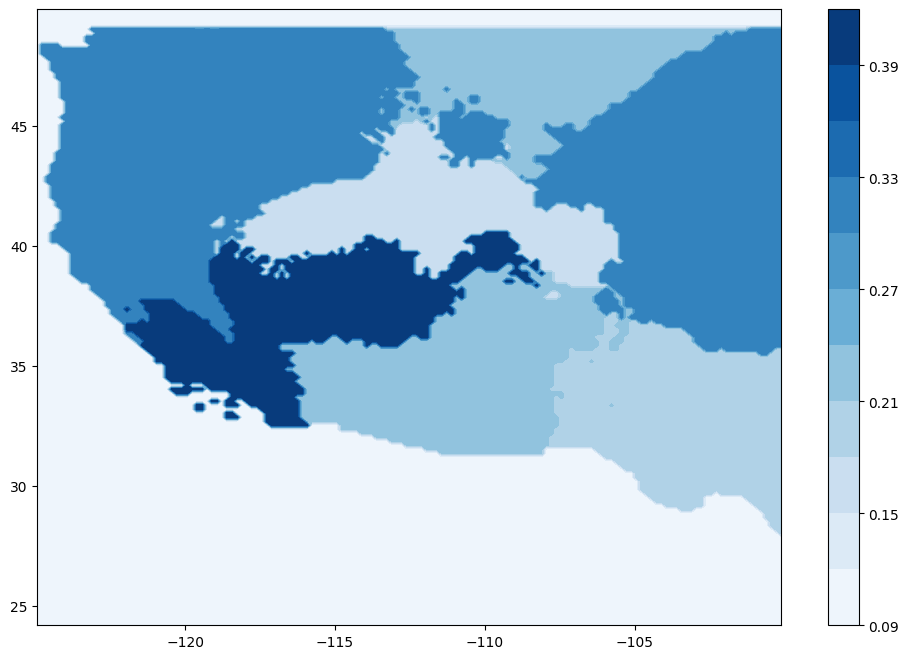

In [65]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


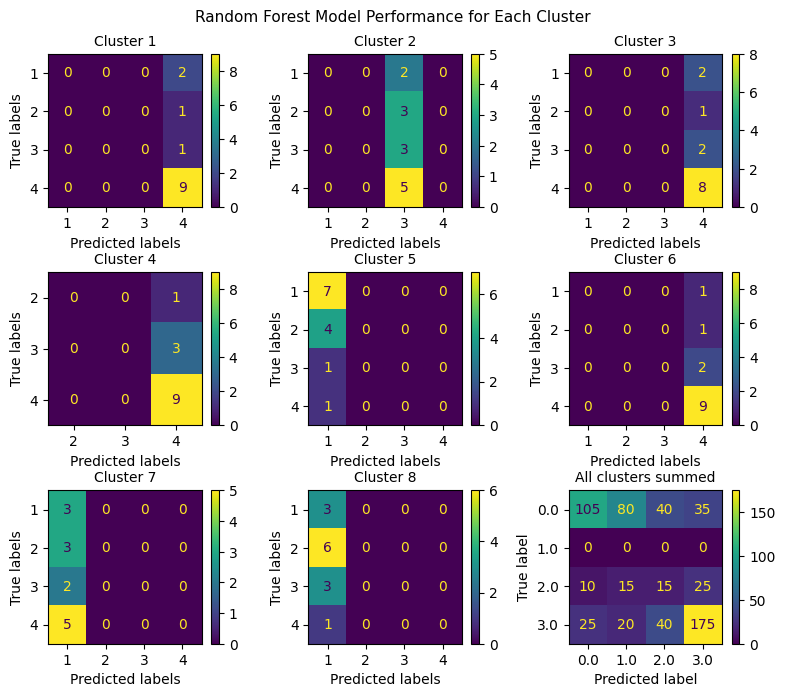

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 8 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 8 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [ ]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## 10. Trying Neural Network

Creating and training a logistic regression model


#### Model


In [ ]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [ ]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(len(clusters)):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")

### Plot Neural Network Confusion Matrices


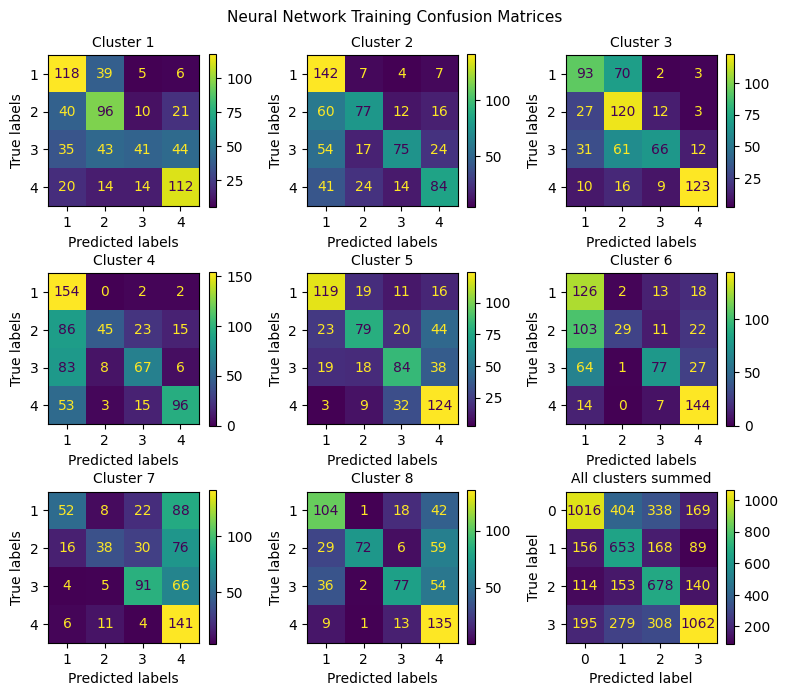

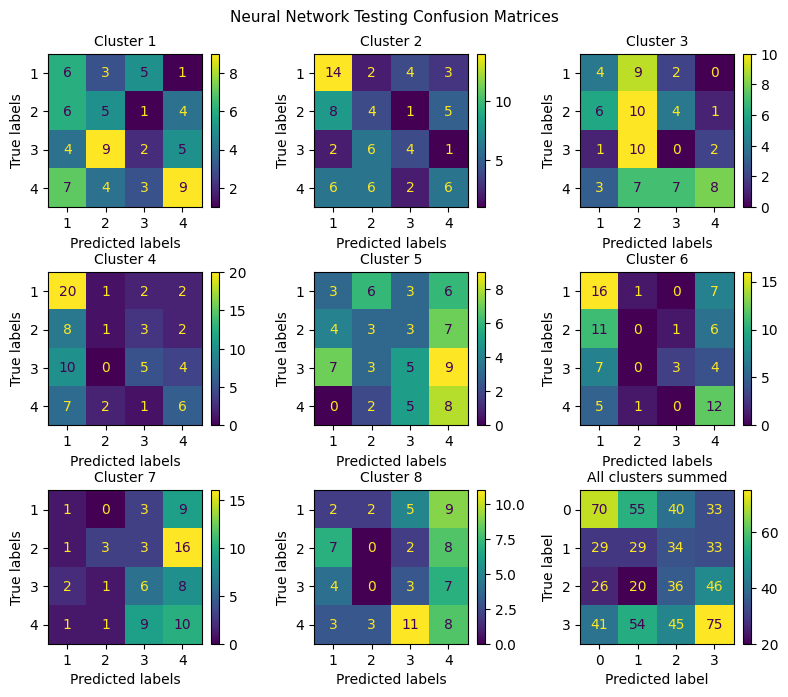

In [ ]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


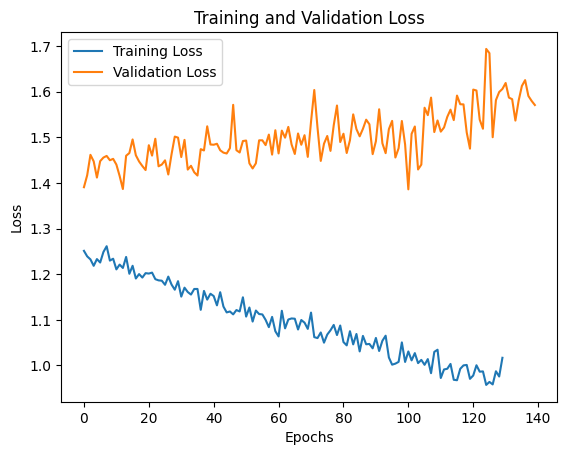

In [ ]:
# Plot and label the training and validation loss values
plt.plot(losses[20:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

## 11. Implement Logistic Regression


/Users/davidenders/Desktop/NN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/davidenders/Desktop/NN/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

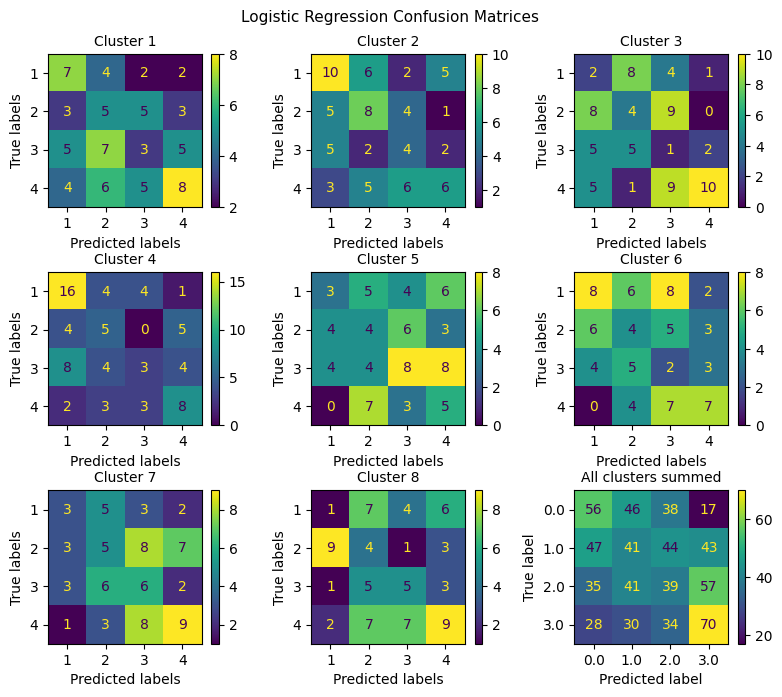

In [ ]:
model = LogisticRegression()

test_preds = []
test_labels = []

for i in range(len(clusters)):
# Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_preds.append(preds.tolist())
    test_labels.append(y_test.tolist())

plot_confusion_matrices(test_preds, test_labels,title="Logistic Regression Confusion Matrices")